In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
from sklearn.metrics import accuracy_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import timm
from statistics import mean
import random
import gc
from scipy.signal import savgol_filter

from tqdm import tqdm
from shared_interest.datasets.imagenet import ImageNet
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, normalize_0to1, binarize_std, binarize_percentile
from interpretability_methods.vanilla_gradients import VanillaGradients

import xml.etree.ElementTree as ET
from torchvision.datasets import ImageFolder
from matplotlib.legend_handler import HandlerPathCollection

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
imagenet_dir = '/nobackup/users/hbang/data/imagenet/val_old/'
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')

In [5]:
# ImageNet transforms.
image_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

In [6]:
dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, 
                                         num_workers=10, pin_memory=True)

In [7]:
transformers = [timm.list_models('*coat*')[0],timm.list_models('*convit*')[0], timm.list_models('*crossvit*')[0],
                timm.list_models('*gcvit*')[0], timm.list_models('*deit3*')[0], timm.list_models('*swin*')[0],
                timm.list_models('*convnext_base*')[0], timm.list_models('*convmixer*')[1], timm.list_models('*pit*')[0],
               timm.list_models('*poolformer*')[0], timm.list_models('*pvt*')[0], timm.list_models('*resmlp*')[0],
               timm.list_models('*twins_pcpvt_base*')[0]]
                
cnn = [timm.list_models('*coatnet*')[-1],timm.list_models('*cs3darknet*')[0], timm.list_models('*gluon*')[0],
       timm.list_models('*ecaresnet*')[0], timm.list_models('*regnetz*')[0],timm.list_models('*inception_v3*')[0],
       timm.list_models('inception_v3')[0], timm.list_models('resnet18')[0], timm.list_models('*resnext50*')[6],
       timm.list_models('vgg16')[0], timm.list_models('*wide_resnet*')[0],timm.list_models('*efficientnet*')[0],
       timm.list_models('*dla60*')[0], timm.list_models('*dpn*')[0], timm.list_models('*fbnet*')[0],
       timm.list_models('*hardcorenas*')[0],timm.list_models('*hrnet*')[0], timm.list_models('*legacy*')[0],
        timm.list_models('*regnetz_b16*')[0], timm.list_models('*res2net50*')[0], timm.list_models('*seresnet*')[0],
       timm.list_models('*skresnet*')[0], timm.list_models('*tf_efficientnetv2*')[0],timm.list_models('*tinynet*')[0]]

models = [timm.list_models('*coatnet*')[-1], timm.list_models('*legacy*')[0], timm.list_models('*dla60*')[0], 
                  timm.list_models('*regnetz*')[0], timm.list_models('resnet18')[0], timm.list_models('*resnext50*')[6],
                  timm.list_models('*wide_resnet*')[0], timm.list_models('vgg16')[0], timm.list_models('*res2net50*')[0],
                  timm.list_models('*seresnet*')[0], timm.list_models('*coat*')[0], timm.list_models('*convit*')[0],
                  timm.list_models('*convmixer*')[1], timm.list_models('*deit3*')[0], timm.list_models('*gcvit*')[0],
                  timm.list_models('*pit*')[0], timm.list_models('*pvt*')[0], timm.list_models('*resmlp*')[0], 
                  timm.list_models('*crossvit*')[0], timm.list_models('*twins_pcpvt_base*')[0]]

In [8]:
# indices of annotations giving GTC of NaN values from dataset
for model_name in models:
    model_path = os.path.abspath("/home/hbang/data/vanilla_gradient/" + model_name + "/")
    with open(os.path.join(model_path, "shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)

gtc_coverage = shared_interest_scores['ground_truth_coverage']
nans = np.array([])
for i in range (0, gtc_coverage.size):
    if np.isnan(gtc_coverage[i]):
        nans = np.append(nans, i)

nans = nans.astype(int)
print (nans)
# print (len(nans))

[ 5463  7509 15345 16151 16194 20090 20265 20273 20276 20295 20297 20323
 20637 20800 20803 20804 20806 20808 20809 20814 20820 20821 20825 20835
 20839 20842 20845 20859 20894 20986 21360 21379 21451 21469 21473 21481
 21482 21494 21501 21504 21510 21518 21520 21521 21522 21535 21542 21548
 21549 21618 21673 21694 21860 21866 21875 21965 22754 22897 23156 23242
 24487 24971 25492 25720 25729 25753 26105 26114 26118 26136 26550 26559
 26812 26818 26829 27852 27891 27929 28488 29075 29250 29274 30107 30111
 30133 30135 30138 30141 30145 30148 30587 30765 31579 32114 32138 32557
 32765 33352 33364 33876 34010 34131 34695 34987 35125 35441 35758 35762
 35763 35764 35772 35773 35776 35777 35781 35782 35785 35786 35787 35789
 35793 35794 35796 35797 36119 36584 36698 37103 37180 37213 37314 37316
 37318 37323 37335 37336 37340 37342 37347 37348 37349 37804 38357 38432
 38441 38777 39263 39680 39697 40280 40939 40941 40944 41617 42043 42149
 42296 42617 42620 42622 42626 42631 43107 44504 44

In [9]:
# indicies of NaN GTC when data loaded in batches of 64 (result from code why_gtc_nan)
nan_ground_truth = {85: [23], 117: [21], 239: [49], 252: [23], 253: [2], 313: [58], 316: [41, 49, 52], 317: [7, 9, 35], 322: [29], 325: [0, 3, 4, 6, 8, 9, 14, 20, 21, 25, 35, 39, 42, 45, 59], 326: [30], 327: [58], 333: [48], 334: [3], 335: [11, 29, 33, 41, 42, 54, 61], 336: [0, 6, 14, 16, 17, 18, 31, 38, 44, 45], 337: [50], 338: [41, 62], 341: [36, 42, 51], 343: [13], 355: [34], 357: [49], 361: [52], 363: [10], 382: [39], 390: [11], 398: [20], 401: [56], 402: [1, 25], 407: [57], 408: [2, 6, 24], 414: [54, 63], 418: [60], 419: [2, 13], 435: [12, 51], 436: [25], 445: [8], 454: [19], 457: [2, 26], 470: [27, 31, 53, 55, 58, 61], 471: [1, 4], 477: [59], 480: [45], 493: [27], 501: [50], 502: [10], 508: [45], 511: [61], 521: [8, 20], 529: [20], 531: [26], 533: [19], 542: [7], 546: [43], 548: [53], 553: [49], 558: [46, 50, 51, 52, 60, 61], 559: [0, 1, 5, 6, 9, 10, 11, 13, 17, 18, 20, 21], 564: [23], 571: [40], 573: [26], 579: [47], 580: [60], 581: [29], 583: [2, 4, 6, 11, 23, 24, 28, 30, 35, 36, 37], 590: [44], 599: [21], 600: [32, 41], 605: [57], 613: [31], 620: [0, 17], 629: [24], 639: [43, 45, 48], 650: [17], 656: [59], 658: [37], 660: [56], 665: [57, 60, 62], 666: [2, 7], 673: [35], 695: [24, 34, 39, 41, 48, 53, 54, 56, 57, 58, 59], 696: [1, 4], 708: [29], 719: [11, 31], 731: [57], 739: [1], 740: [24], 742: [45], 743: [32], 771: [45]}
print (nan_ground_truth)

{85: [23], 117: [21], 239: [49], 252: [23], 253: [2], 313: [58], 316: [41, 49, 52], 317: [7, 9, 35], 322: [29], 325: [0, 3, 4, 6, 8, 9, 14, 20, 21, 25, 35, 39, 42, 45, 59], 326: [30], 327: [58], 333: [48], 334: [3], 335: [11, 29, 33, 41, 42, 54, 61], 336: [0, 6, 14, 16, 17, 18, 31, 38, 44, 45], 337: [50], 338: [41, 62], 341: [36, 42, 51], 343: [13], 355: [34], 357: [49], 361: [52], 363: [10], 382: [39], 390: [11], 398: [20], 401: [56], 402: [1, 25], 407: [57], 408: [2, 6, 24], 414: [54, 63], 418: [60], 419: [2, 13], 435: [12, 51], 436: [25], 445: [8], 454: [19], 457: [2, 26], 470: [27, 31, 53, 55, 58, 61], 471: [1, 4], 477: [59], 480: [45], 493: [27], 501: [50], 502: [10], 508: [45], 511: [61], 521: [8, 20], 529: [20], 531: [26], 533: [19], 542: [7], 546: [43], 548: [53], 553: [49], 558: [46, 50, 51, 52, 60, 61], 559: [0, 1, 5, 6, 9, 10, 11, 13, 17, 18, 20, 21], 564: [23], 571: [40], 573: [26], 579: [47], 580: [60], 581: [29], 583: [2, 4, 6, 11, 23, 24, 28, 30, 35, 36, 37], 590: [44], 

In [ ]:
def run(model, dataloader, saliency_method, nan_ground_truth, smooth = False, stop_after=None):
    """
    Runs the model through the data in the dataloader and computes the 
    predictions, saliency, and Shared Interest scores.
    
    Args:
    model: pytorch model to evaluate.
    dataloader: dataloader to evaluate the model on. Should output an image,
        ground truth, and label for each index.
    saliency_method: the InterpretabilityMethod to use to compute Shared
        Interest.
    nan_ground_truth: indicies of annotations with GTC of 0s in batches of 64 
    smooth: optional boolean on whether the saliency should be smoothed 
    stop_after: optional integer that determins when to stop the evaluation.
        Used here for efficiency in the notebook. If None, entire process will
        run.
    """
    model.eval()
    accuracy = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    
    total_predictions = np.array([])
    total_saliency_masks = np.array([[[]]])
    
    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader, position=0, leave=True)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()
            
            # eliminate the images, ground_truth, and labels that give ground_truth of 0s
            if i in nan_ground_truth:
                nans = nan_ground_truth[i]
                for j in sorted(nans, reverse=True):
                    images = torch.cat([images[0:j], images[j+1:]])
                ground_truth = np.delete(ground_truth, nans, 0)
                labels = np.delete(labels, nans, 0)

            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, predictions))

            # Update metrics
            accuracy += accuracy_score(labels, predictions)
                        
        # Compute saliency
        if smooth:
            saliency = flatten(saliency_method.get_saliency_smoothed(images, num_samples=5))
        else: 
            saliency = flatten(saliency_method.get_saliency(images))
            
        saliency_masks = binarize_std(saliency)
        
        if i == 0: 
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
        
        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))
      
        # Stop early for this example notebook
        if stop_after and stop_after == i:
            break
    accuracy /= i + 1
    print('Accuracy: %.2f' %accuracy)
    return accuracy, total_saliency_masks, total_shared_interest_scores, total_predictions

In [ ]:
# validate the models and save accuracy, shared interest scores

torch.cuda.empty_cache()
for model_name in models:
    data_path = os.path.abspath("/home/hbang/data/rerun/" + model_name + "/")
    if os.path.exists(data_path):
        continue 

    print (model_name)
    model = timm.create_model(model_name, pretrained=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    try:
        accuracy, saliency_masks, shared_interest_scores, predictions = run(model, dataloader, VanillaGradients(model), nan_ground_truth)
        if not os.path.exists(data_path):
            os.mkdir(data_path)
        
        with open(os.path.join(data_path, "accuracy.pickle"), "wb") as handle:
            pickle.dump(accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
            del accuracy

        with open(os.path.join(data_path, "shared_interest_scores.pickle"), "wb") as handle:
            pickle.dump(shared_interest_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
            del shared_interest_scores
    except:
        print ("error while: " + model_name)
    torch.cuda.empty_cache()

In [10]:
# get accuracies for each model

model_accuracy = {}
for model_name in models:
    model_path = os.path.abspath("/home/hbang/data/vanilla_gradient/" + model_name + "/")
    if os.path.exists(model_path):
        with open(os.path.join(model_path, "accuracy.pickle"), 'rb') as handle:
            accuracy = pickle.load(handle)
            model_accuracy[model_name] = accuracy 

print(sorted(model_accuracy.items(), key=lambda x:x[1]))
# print (len(model_accuracy))

[('resnet18', 0.69758), ('pvt_v2_b0', 0.70326), ('legacy_seresnet18', 0.71458), ('vgg16', 0.71592), ('crossvit_9_240', 0.7353900255754476), ('resmlp_12_224', 0.76506), ('coatnet_rmlp_nano_rw_224', 0.7667039641943734), ('convmixer_1024_20_ks9_p14', 0.77012), ('dla60', 0.77022), ('res2net50_14w_8s', 0.78152), ('haloregnetz_b', 0.786377078005115), ('coat_lite_mini', 0.7884830562659847), ('resnext50_32x4d', 0.80886), ('legacy_senet154', 0.81304), ('wide_resnet50_2', 0.81416), ('convit_base', 0.8227), ('pit_b_224', 0.82278), ('twins_pcpvt_base', 0.82552), ('deit3_base_patch16_224', 0.8368726023017904), ('gcvit_base', 0.84356)]


In [11]:
# get average scores for each model

model_scores = {} 
for model_name in model_accuracy: 
    model_path = os.path.abspath("/home/hbang/data/rerun/" + model_name + "/")
    model_scores[model_name] = {}
    
    with open(os.path.join(model_path, "shared_interest_scores.pickle"), 'rb') as handle:
        shared_interest_scores = pickle.load(handle)
        
        for score in shared_interest_scores.keys():
            scores = shared_interest_scores[score]
            model_scores[model_name][score] = mean(scores)

In [12]:
print (model_scores)

{'coatnet_rmlp_nano_rw_224': {'iou_coverage': 0.09207102542961469, 'ground_truth_coverage': 0.10990759313493957, 'saliency_coverage': 0.5970410973988791}, 'legacy_senet154': {'iou_coverage': 0.12405803421434898, 'ground_truth_coverage': 0.1460352579556148, 'saliency_coverage': 0.7065759788986008}, 'dla60': {'iou_coverage': 0.1392294234759405, 'ground_truth_coverage': 0.16189106896813948, 'saliency_coverage': 0.7538569952216523}, 'haloregnetz_b': {'iou_coverage': 0.1447579288612269, 'ground_truth_coverage': 0.16866758635557128, 'saliency_coverage': 0.7736026106386361}, 'resnet18': {'iou_coverage': 0.13638949466279415, 'ground_truth_coverage': 0.15830209084011887, 'saliency_coverage': 0.7349542398502001}, 'resnext50_32x4d': {'iou_coverage': 0.1309198009111051, 'ground_truth_coverage': 0.15318152964617604, 'saliency_coverage': 0.7157866672191854}, 'wide_resnet50_2': {'iou_coverage': 0.12298812458630237, 'ground_truth_coverage': 0.1441669601781413, 'saliency_coverage': 0.7023149345285485},

In [13]:
# 20 distinct, vivid colors for plots 
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#f0e68c', '#800000', '#aaffc3', '#808000', '#e9967a', '#000075', '#808080', '#ffffff', '#000000']

In [14]:
# computing size of model by number of parameters

model_size = {}
for model_name in models: 
    model = timm.create_model(model_name, pretrained=True)
    model_size[model_name] = sum(p.numel() for p in model.parameters())
print (model_size)

# scaling the models' sizes for plotting 

scaled_model_size = model_size.copy()
for model_name in models: 
    scaled_model_size[model_name] = model_size[model_name] / 150000

{'coatnet_rmlp_nano_rw_224': 15145116, 'legacy_senet154': 115088984, 'dla60': 22036632, 'haloregnetz_b': 11680072, 'resnet18': 11689512, 'resnext50_32x4d': 25028904, 'wide_resnet50_2': 68883240, 'vgg16': 138357544, 'res2net50_14w_8s': 25059816, 'legacy_seresnet18': 11778592, 'coat_lite_mini': 11011560, 'convit_base': 86540040, 'convmixer_1024_20_ks9_p14': 24383464, 'deit3_base_patch16_224': 86585320, 'gcvit_base': 90320836, 'pit_b_224': 73764840, 'pvt_v2_b0': 3666760, 'resmlp_12_224': 15350872, 'crossvit_9_240': 8553296, 'twins_pcpvt_base': 43828456}


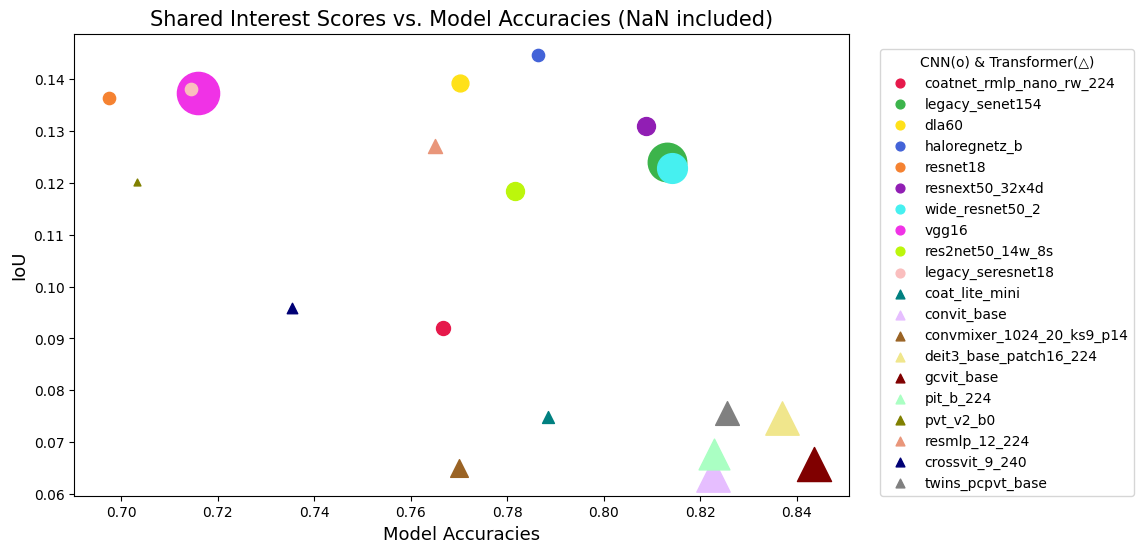

In [15]:
# plotting IoU vs. Accuracies of 20 models 

plt.figure(figsize=(10,6))
i = 0
for model_name in model_accuracy: 
    x = model_accuracy[model_name]
    if model_name in cnn:
        y = model_scores[model_name]['iou_coverage']
        sc = plt.scatter(x, y, s = scaled_model_size[model_name], c = colors[i], label=model_name)
    elif model_name in transformers:
        y = model_scores[model_name]['iou_coverage']
        sc = plt.scatter(x, y, s = scaled_model_size[model_name], c = colors[i], marker='^', label=model_name)
    i += 1
    
plt.title("Shared Interest Scores vs. Model Accuracies (NaN included)", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("IoU", fontdict={'fontsize': 13})
marker_size = 40
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.legend(loc=(1.04, 0), handler_map={type(sc): HandlerPathCollection(update_func=update_prop)}, title = 'CNN(o) & Transformer(△)')

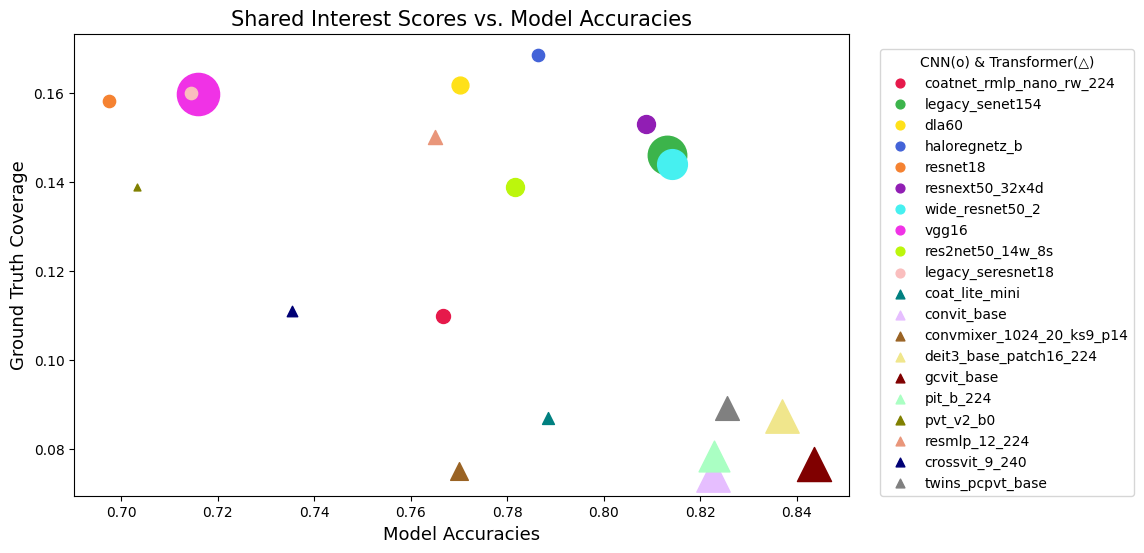

In [25]:
# plotting GTC vs. Accuracies of 20 models 

plt.figure(figsize=(10,6))
i = 0
for model_name in model_accuracy: 
    x = model_accuracy[model_name]
    if model_name in cnn:
        y = model_scores[model_name]['ground_truth_coverage']
        plt.scatter(x, y, s = scaled_model_size[model_name], c = colors[i], label=model_name)
    elif model_name in transformers:
        y = model_scores[model_name]['ground_truth_coverage']
        plt.scatter(x, y, s = scaled_model_size[model_name], c = colors[i], marker='^', label=model_name)
    i += 1
    
plt.title("Shared Interest Scores vs. Model Accuracies", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("Ground Truth Coverage", fontdict={'fontsize': 13})

marker_size = 40
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.legend(loc=(1.04, 0), handler_map={type(sc): HandlerPathCollection(update_func=update_prop)}, title = 'CNN(o) & Transformer(△)')

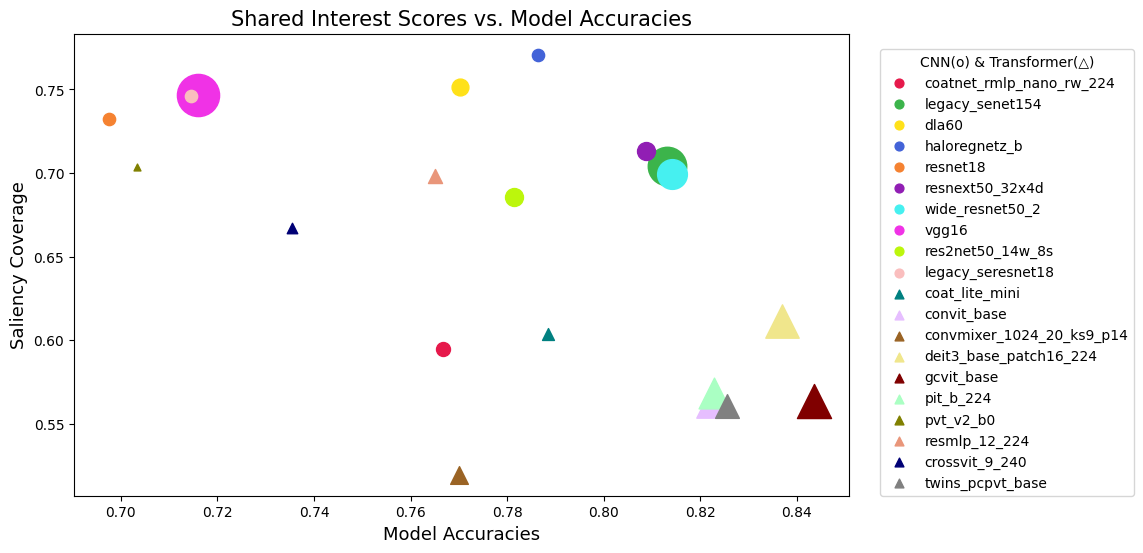

In [26]:
# plotting Saliency Coverage vs. Accuracies of 20 models 

plt.figure(figsize=(10,6))
i = 0
for model_name in model_accuracy: 
    x = model_accuracy[model_name]
    if model_name in cnn:
        y = model_scores[model_name]['saliency_coverage']
        plt.scatter(x, y, s = scaled_model_size[model_name], c = colors[i], label=model_name)
    elif model_name in transformers:
        y = model_scores[model_name]['saliency_coverage']
        plt.scatter(x, y, s = scaled_model_size[model_name], c = colors[i], marker='^', label=model_name)
    i += 1
    
plt.title("Shared Interest Scores vs. Model Accuracies", fontdict={'fontsize': 15})
plt.xlabel("Model Accuracies", fontdict={'fontsize': 13})
plt.ylabel("Saliency Coverage", fontdict={'fontsize': 13})

marker_size = 40
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.legend(loc=(1.04, 0), handler_map={type(sc): HandlerPathCollection(update_func=update_prop)}, title = 'CNN(o) & Transformer(△)')

In [13]:
# average bounding box per batch 

total_ground_ratio = np.array([])
for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader, position=0, leave=True)):
    with torch.no_grad():
        ground_truth = ground_truth.numpy()
        if i in nan_ground_truth:
            ground_truth = np.delete(ground_truth, nan_ground_truth[i], 0)
        ground_area = ground_truth.shape[1] * ground_truth.shape[2]
        ground_ratio = [(matrix.sum() / ground_area) for matrix in ground_truth]

        total_ground_ratio = np.concatenate((total_ground_ratio, ground_ratio))

# print (total_ground_ratio.size)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [06:49<00:00,  1.91it/s]

49815


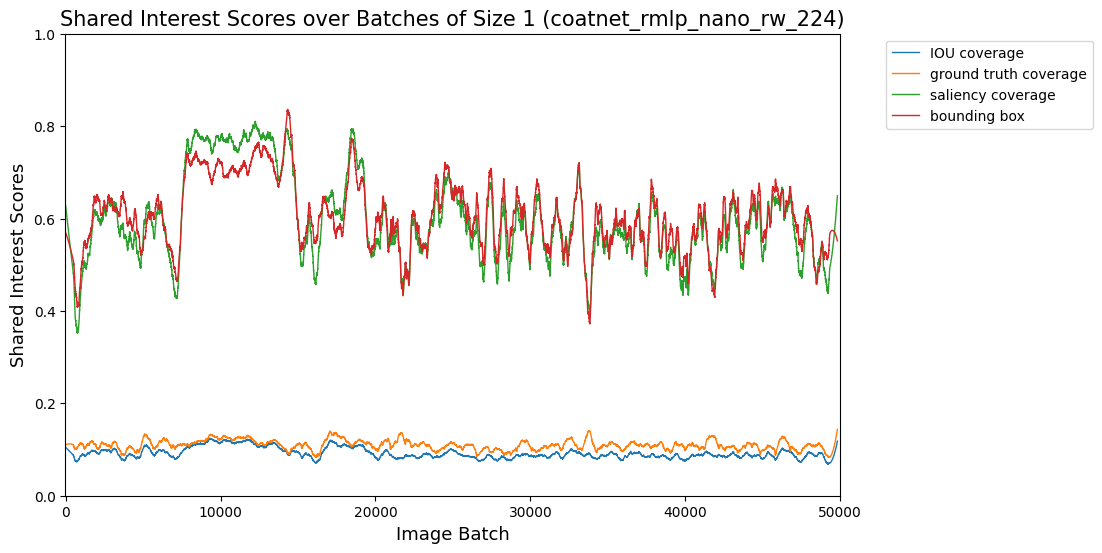

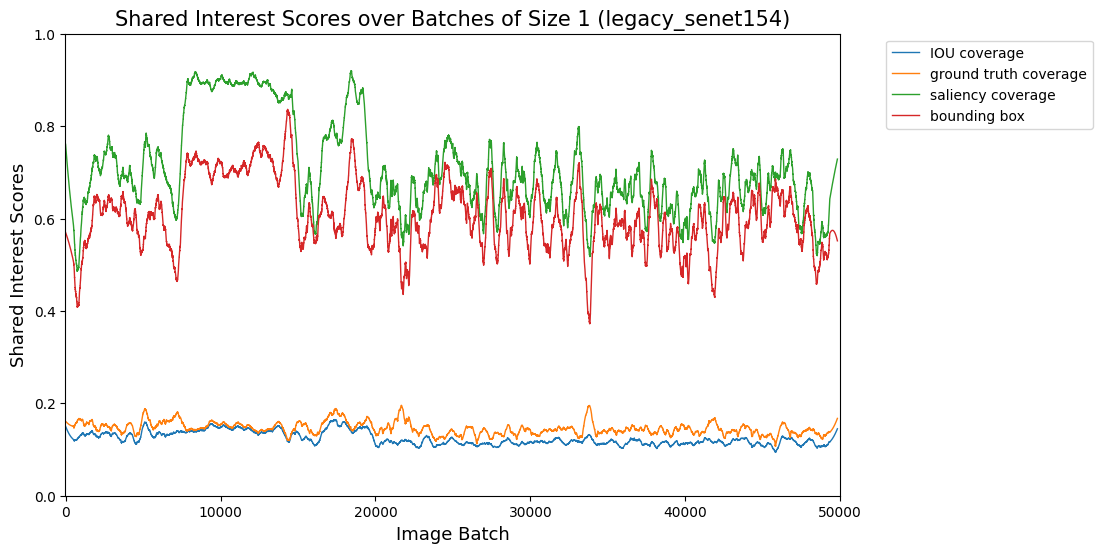

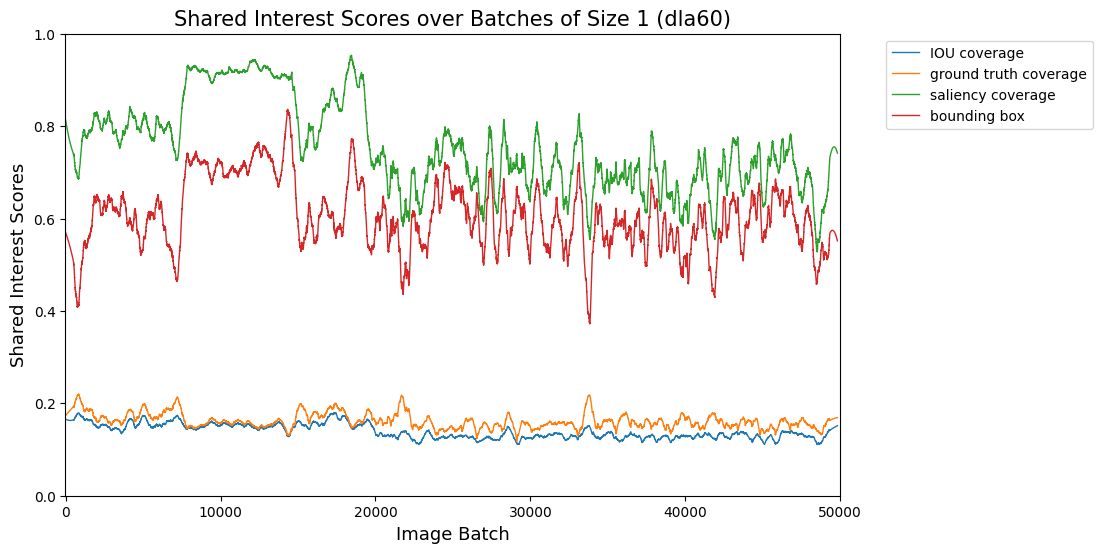

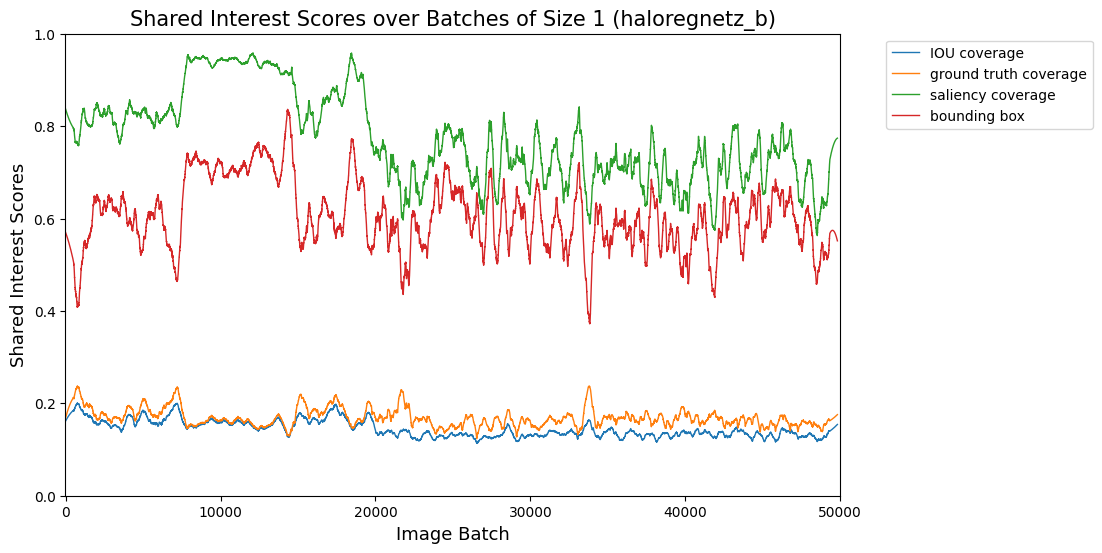

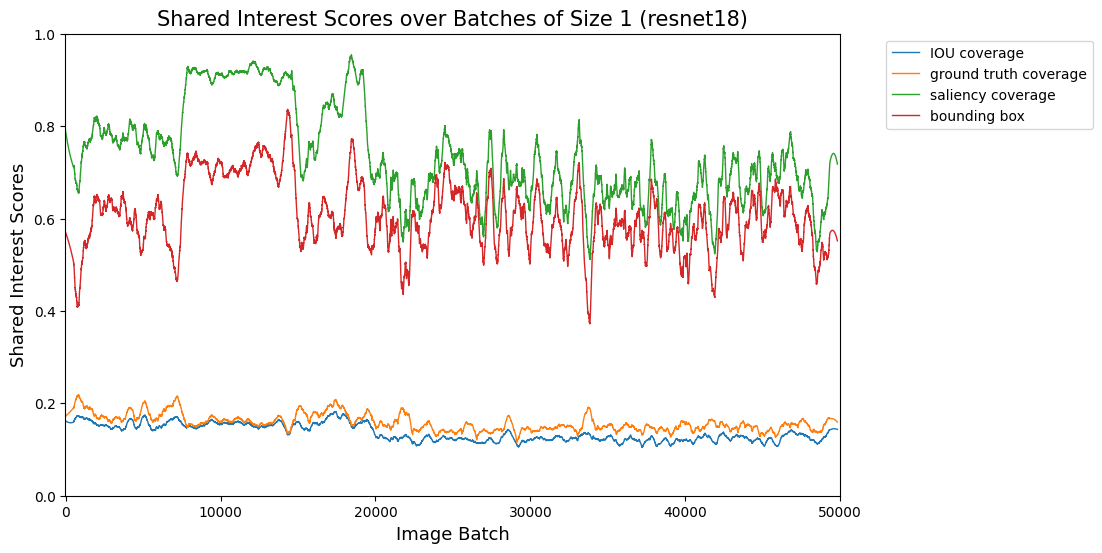

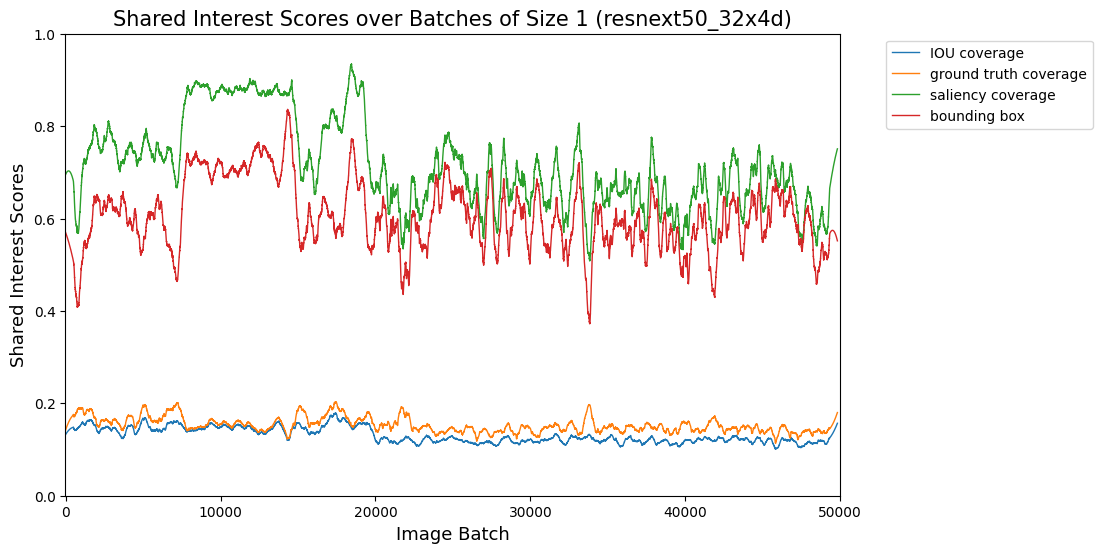

In [18]:
# plotting Shared Interest Scores over images batches (specifically batches of 1 in this case) 

for model_name in models: 
    data_path = os.path.abspath("/home/hbang/data/rerun/batch_1/" + model_name + "/")
    if not os.path.exists(data_path):
        continue
    try:
        with open(os.path.join(os.path.abspath("/home/hbang/data/rerun/"), "total_ground_ratio.pickle"), 'rb') as handle:
            total_ground_ratio = pickle.load(handle)
            
        with open(os.path.join(data_path, "shared_interest_scores.pickle"), 'rb') as handle:
            shared_interest_scores = pickle.load(handle)

        iou_coverage = shared_interest_scores['iou_coverage']
        gtc_coverage = shared_interest_scores['ground_truth_coverage']
        saliency_coverage = shared_interest_scores['saliency_coverage']
        
        plt.figure(figsize=(10,6))
        plt.xlim(-20,50000)
        plt.ylim(0.0,1.0)

        iou = savgol_filter(iou_coverage, 1001, 2)
        plt.plot(np.arange(0, iou.size), iou, linewidth = 1, label="IOU coverage")
        gtc = savgol_filter(gtc_coverage, 1001, 2)
        plt.plot(np.arange(0, gtc.size), gtc, linewidth = 1, label="ground truth coverage")
        sc = savgol_filter(saliency_coverage, 1001, 2)
        plt.plot(np.arange(0, sc.size), sc, linewidth = 1, label="saliency coverage")

        b = savgol_filter(total_ground_ratio, 1001, 2)
        plt.plot(np.arange(0, b.size), b, linewidth = 1, label = "bounding box")

        plt.title("Shared Interest Scores over Batches of Size 1 (" + model_name +")", fontdict={'fontsize': 15})
        plt.xlabel("Image Batch", fontdict={'fontsize': 13})
        plt.ylabel("Shared Interest Scores", fontdict={'fontsize': 13})
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.show()
    except:
        print (model_name)

In [ ]:
# calculating Pearson correlation on above plots

data_path = os.path.abspath("/home/hbang/data/rerun/batch_1/" + model_name + "/")
bb_path = os.path.abspath("/home/hbang/data/rerun/")

with open(os.path.join(data_path, "shared_interest_scores.pickle"), 'rb') as handle:
    shared_interest_scores = pickle.load(handle)
iou_coverage = shared_interest_scores['iou_coverage']
gtc_coverage = shared_interest_scores['ground_truth_coverage']
saliency_coverage = shared_interest_scores['saliency_coverage']

with open(os.path.join(bb_path, "total_ground_ratio.pickle"), 'rb') as handle:
    total_ground_ratio = pickle.load(handle)

# Pearson correlation coefficient and p-value

# close to no correlation 
print (scipy.stats.pearsonr(iou_coverage, total_ground_ratio))
# minimal negative correlation 
print (scipy.stats.pearsonr(gtc_coverage, total_ground_ratio))
# strong positive correlation 
print (scipy.stats.pearsonr(saliency_coverage, total_ground_ratio))